In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
import os
device_mappings = {0: 1, 1: 5, 2: 6, 3: 7, 4: 2, 5: 3, 6: 0, 1: 4}
os.environ["CUDA_VISIBLE_DEVICES"] = str(device_mappings[2])

import random
import string
import json
from collections import defaultdict, OrderedDict
from itertools import product, chain
import math
import numpy as np
from pattern.en import comparative

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
from utils import *

TRANSFORMERS_CACHE = /home/xd/.cache/torch/transformers


In [16]:
lines2 = [line.strip() for line in open('/nas/xd/projects/anli/data/build/mnli/train.jsonl').readlines()]

In [38]:
lines3 = [line.strip() for line in open('/nas/xd/projects/anli/data/build/fever_nli/train.jsonl').readlines()]

In [8]:
lines = [line.strip() for line in open('/nas/xd/projects/anli/data/build/anli/r1/train.jsonl').readlines()]

lines += [line.strip() for line in open('/nas/xd/projects/anli/data/build/anli/r1/dev.jsonl').readlines()]
lines += [line.strip() for line in open('/nas/xd/projects/anli/data/build/anli/r1/test.jsonl').readlines()]
len(lines)

In [43]:
d_list = [json.loads(line) for line in lines3]

In [44]:
premises = [d['premise'] for d in d_list]

In [45]:
n_hypo = defaultdict(int)
for d in d_list:
    n_hypo[d['premise']] += 1

In [46]:
len(premises)
len(n_hypo)

208346

87837

In [53]:
print(random.sample(list(n_hypo.values()), 20))

[1, 1, 1, 2, 1, 22, 1, 1, 3, 1, 1, 1, 1, 7, 1, 1, 1, 2, 1, 1]


In [27]:
print(random.sample(n_hypo, 20))

[5, 8, 7, 8, 10, 1, 7, 5, 6, 8, 15, 9, 7, 8, 8, 17, 9, 6, 5, 4]


In [ ]:
print(random.sample(n_hypo, 20))

In [5]:
hg_model_hub_name = "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"
tokenizer = AutoTokenizer.from_pretrained(hg_model_hub_name)
mask = tokenizer.mask_token

In [7]:
tokenizer.convert_tokens_to_ids([tokenizer.pad_token])

[1]

In [66]:
model = AutoModelForSequenceClassification.from_pretrained(hg_model_hub_name)
_ = model.eval()

loading state_dict took 2.814 sec


In [118]:
labels = ['e', 'n', 'c']

In [328]:
for start in range(2, 6, 4):
    stop = min(180, start + 4)
    batch_text_pairs = [[json.loads(line)[k] for k in ['premise', 'hypothesis']] for line in lines[start: stop]]
#     batch_text_pairs = [r[:2] for r in rows[start: stop]]
    inputs = tokenizer.batch_encode_plus(batch_text_pairs, return_token_type_ids=True, padding=True, return_tensors='pt')
    with torch.no_grad(): outputs = model(**inputs)

    probs = outputs[0].softmax(dim=-1)
    bvalues, bindices = probs.topk(2, dim=-1)
    for values, indices in zip(bvalues, bindices):
        print(labels[indices[0].item()], round(values[0].item(), 6), labels[indices[1].item()], round(values[1].item(), 6))
#     [[(labels[i.item()], round(v.item(), 4)) for i, v in zip(indices, values)] for values, indices in zip(bvalues, bindices)]

n 0.999638 e 0.000288
n 0.99584 e 0.003969
e 0.997824 c 0.001999
e 0.995415 c 0.004439


In [321]:
premise, hypothesis = rows[163][:2]
premise = "Taina is an American sitcom that aired on Nickelodeon. It was taped at Nickelodeon Studios but later moved to the Nickelodeon on Sunset in Hollywood, for its second season."
# hypothesis = "Bill Hargate is known for dying from leukemia."
premise, hypothesis

('Taina is an American sitcom that aired on Nickelodeon. It was taped at Nickelodeon Studios but later moved to the Nickelodeon on Sunset in Hollywood, for its second season.',
 'Nickelodeon Studios is located on Sunset in Hollywood.')

In [322]:
inputs = tokenizer.encode_plus(premise, hypothesis, return_token_type_ids=True, return_tensors='pt')
outputs = model(**inputs)
list(zip(['e', 'n', 'c'], torch.softmax(outputs[0], dim=1)[0].tolist()))

[('e', 0.9337389469146729),
 ('n', 0.06481590121984482),
 ('c', 0.0014451614115387201)]

In [106]:
badcase_idx = [36, 55, 107, 109, 118, 159]

In [65]:
models = {}
models['roberta-large'] = model

In [4]:
model = AutoModelForMaskedLM.from_pretrained('roberta-large')
_ = model.eval()

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loading state_dict took 2.798 sec


In [323]:
lines = open('/nas/xd/projects/anli/data/build/anli/r3/dev.jsonl').readlines()
lines.insert(0, '')
lines.insert(0, '')

In [ ]:
for line in random.sample(lines, 10):
    example = json.loads(line)
    print(example['premise'])

In [8]:
line = random.choice(lines)
e = json.loads(line)
p, h = e['premise'], e['hypothesis']
assert h[-1] == '.' or h[-1].isalpha(), h
if h[-1] == '.':
    assert h[-2].isalpha(), h
    h = h[:-1]
h = h + '?'
text = '%s %s. %s' % (h, mask, p)
text

"One couldn't tell if a school is an independent or consolidated school district? <mask>. In the state of Texas, United States, local schools are typically operated as independent school districts or consolidated school districts. Consolidated School Districts are typically one or more independent school districts that were consolidated due to low attendance or governance issues. Independent School Districts typically serve one community, but sometimes serve multiple small communities."

In [34]:
inputs = tokenizer.encode_plus(text, return_token_type_ids=False, return_tensors='pt')
outputs = model(**inputs)

In [32]:
H, L = model.config.num_attention_heads, model.config.num_hidden_layers

/home/kf/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


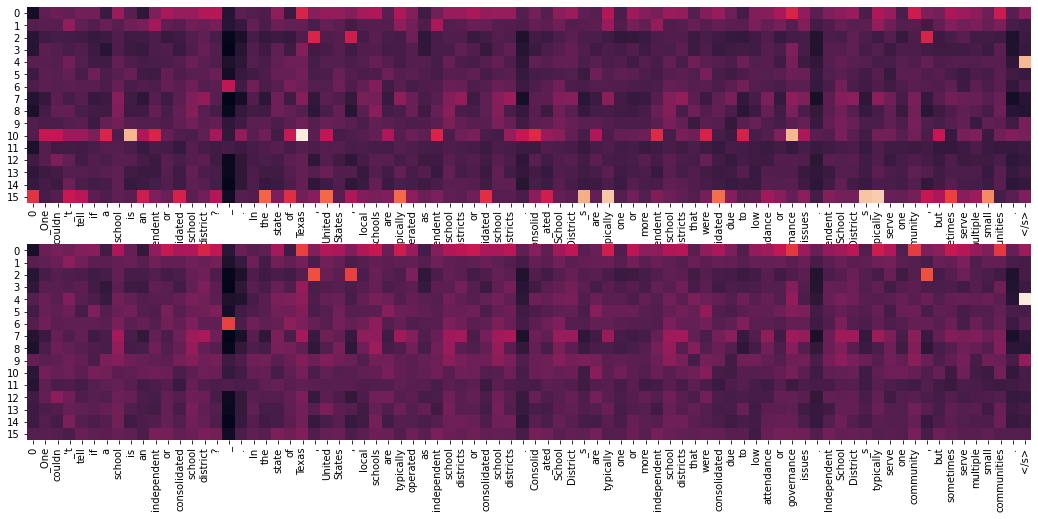

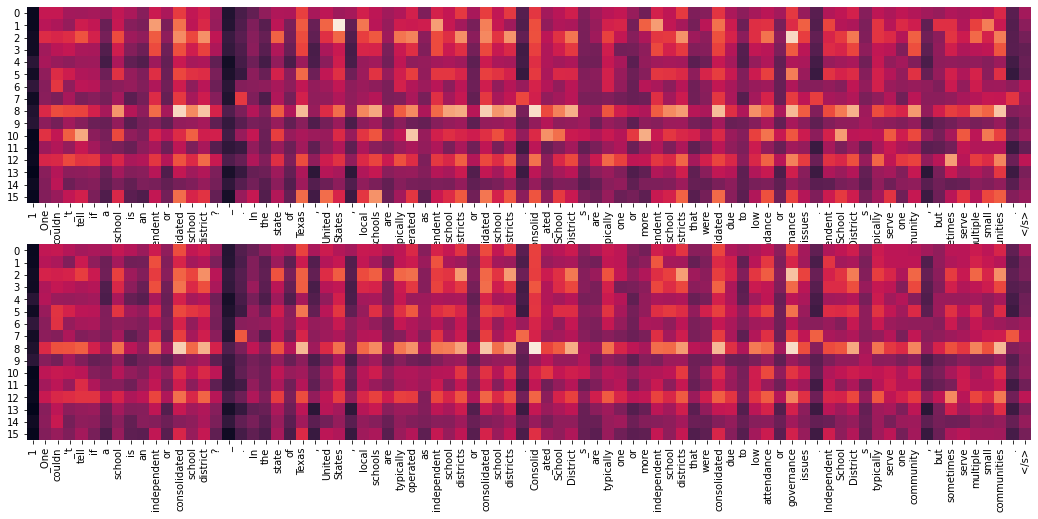

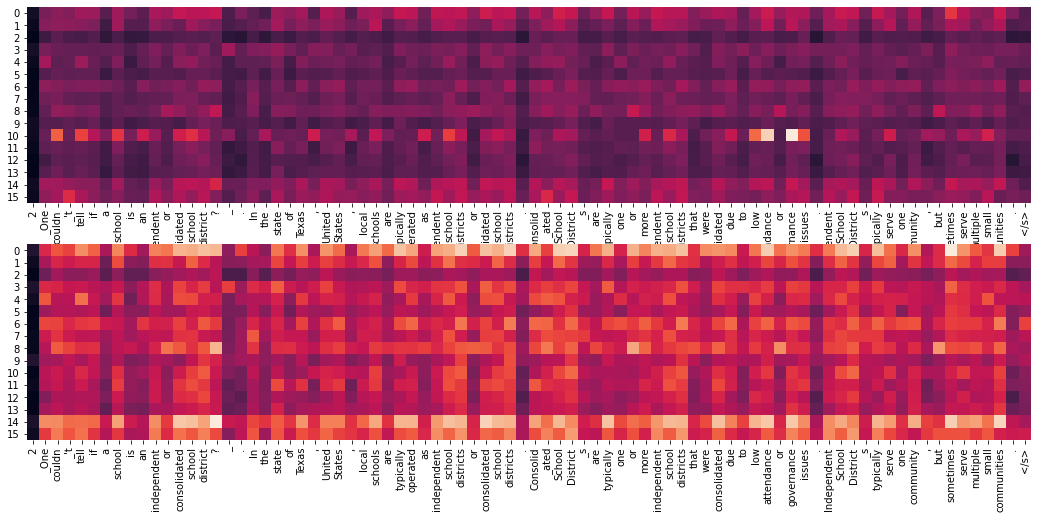

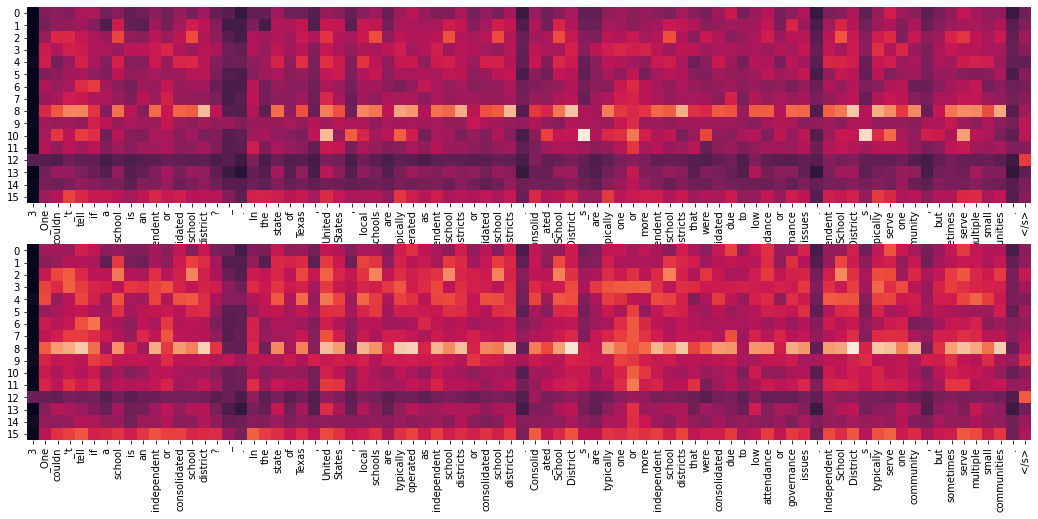

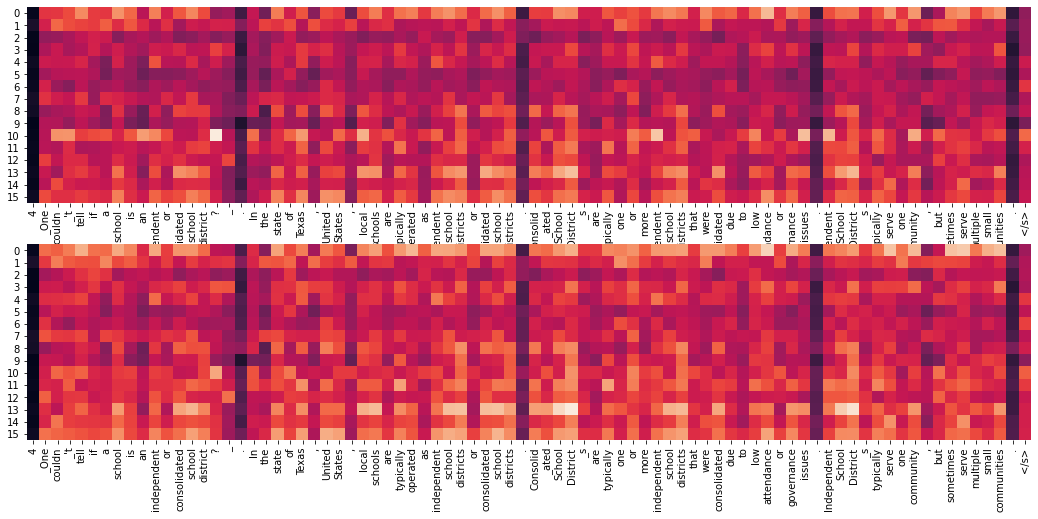

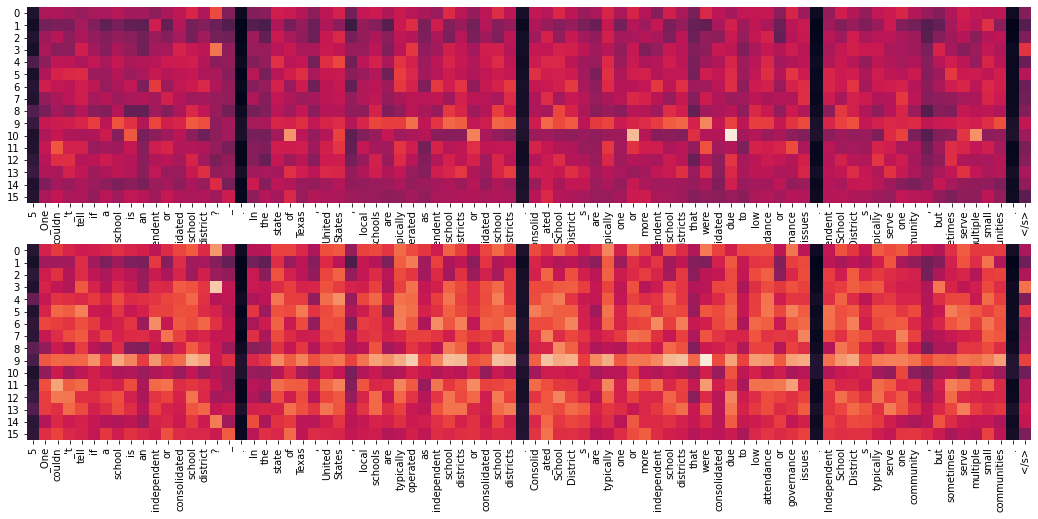

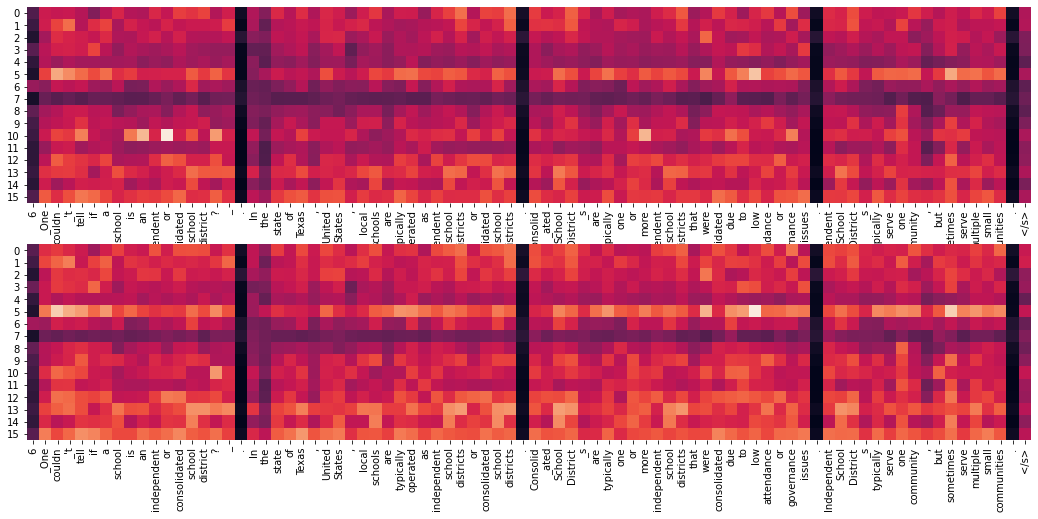

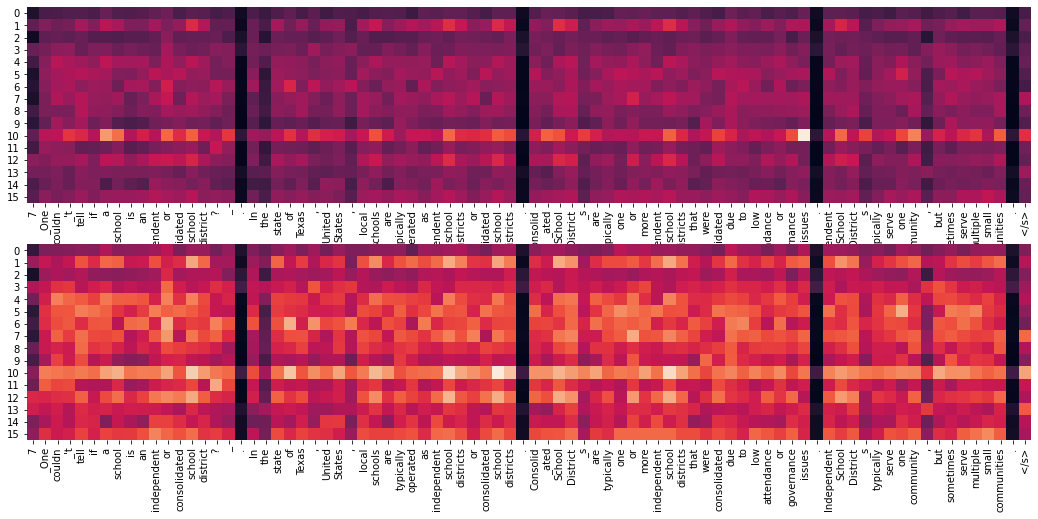

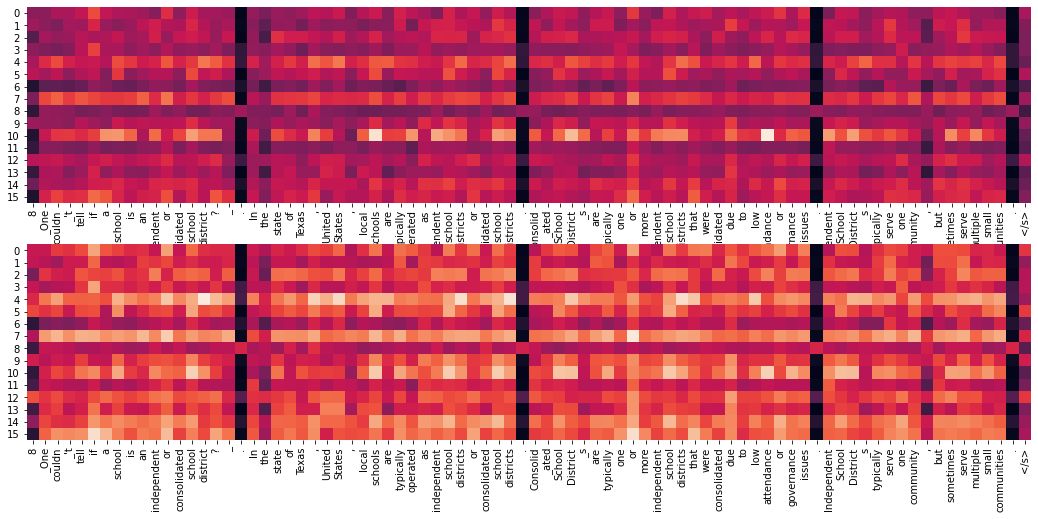

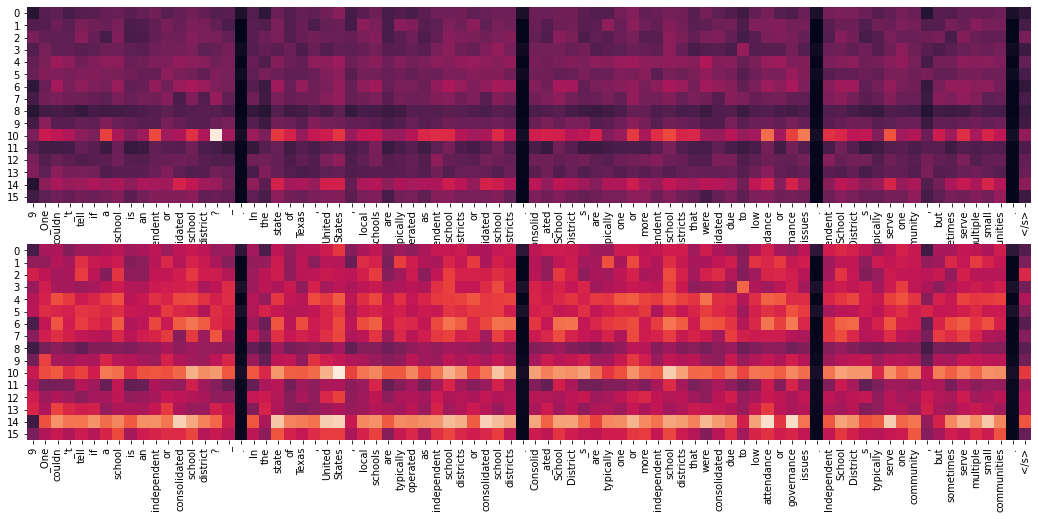

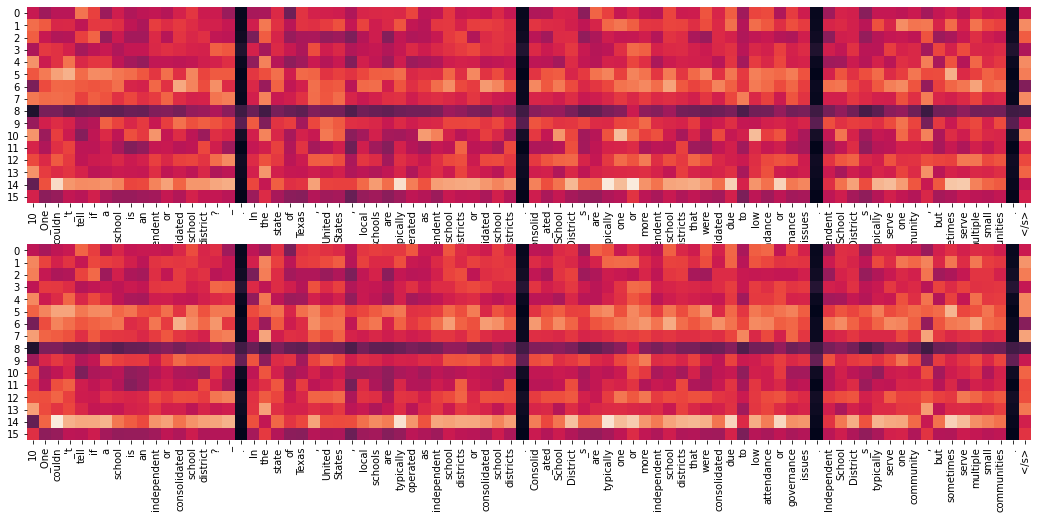

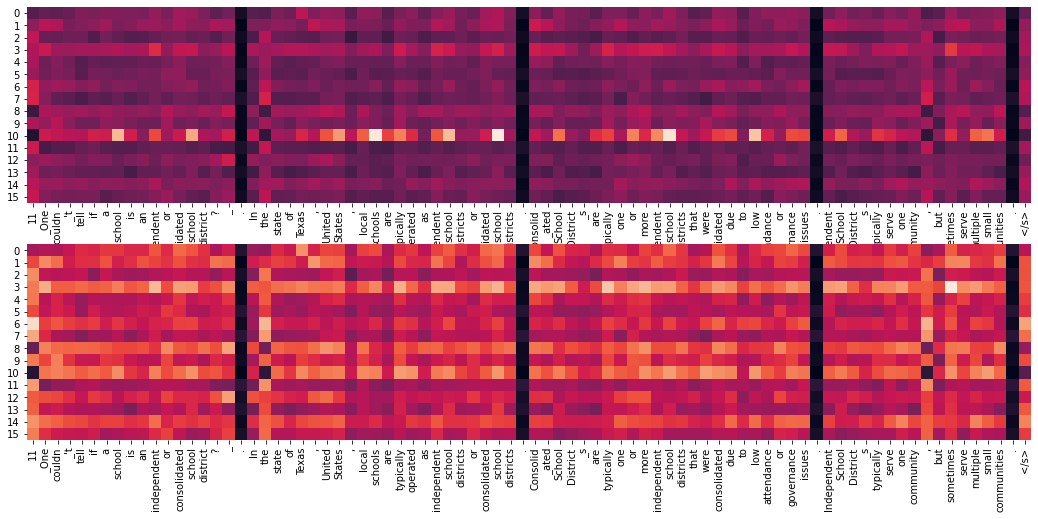

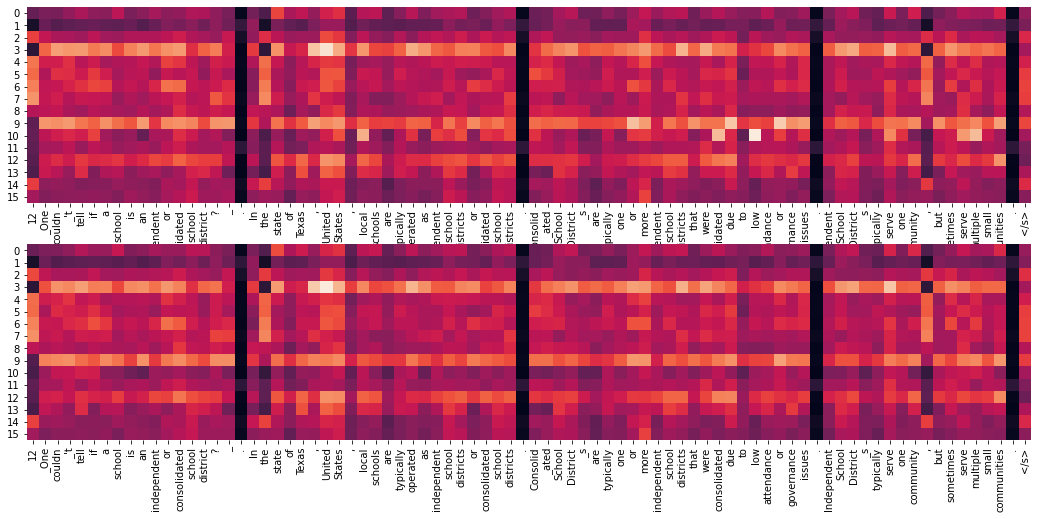

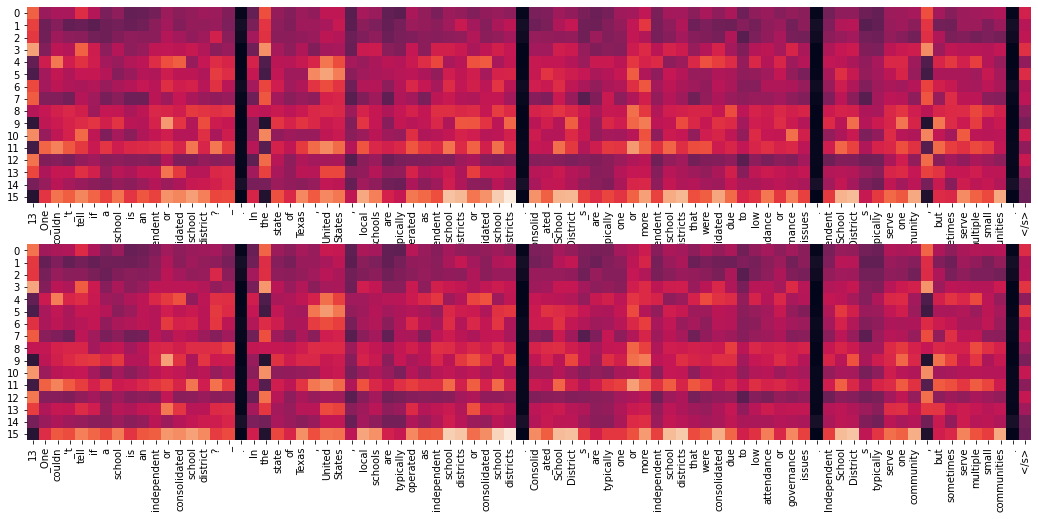

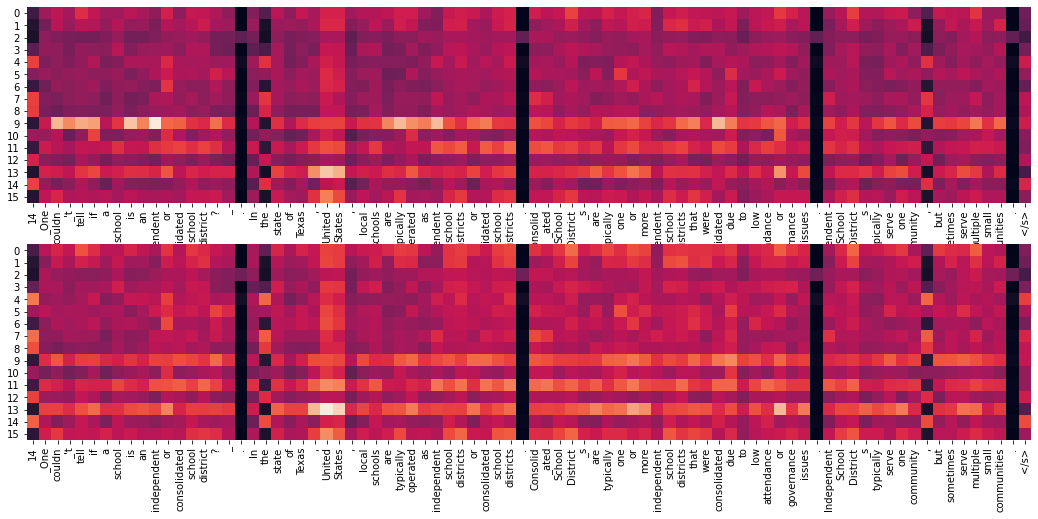

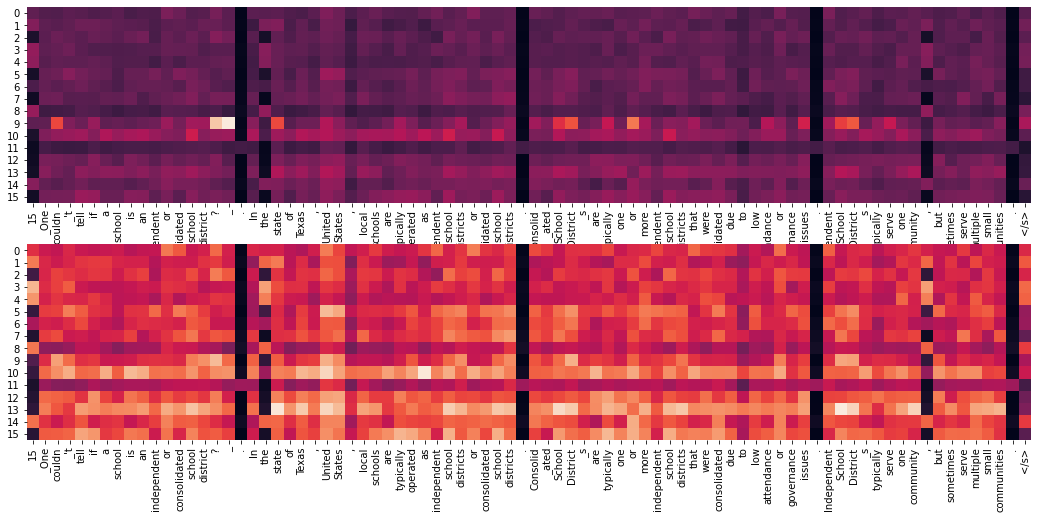

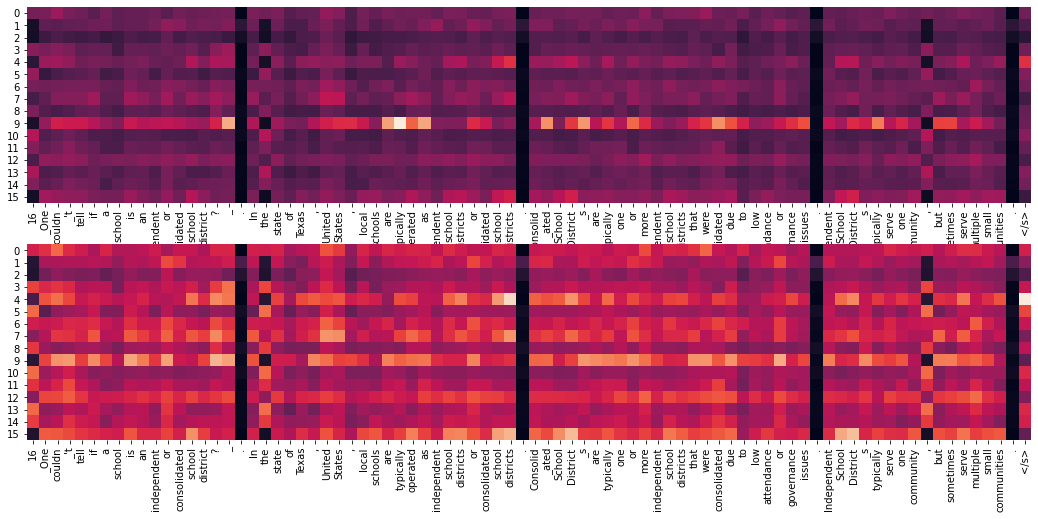

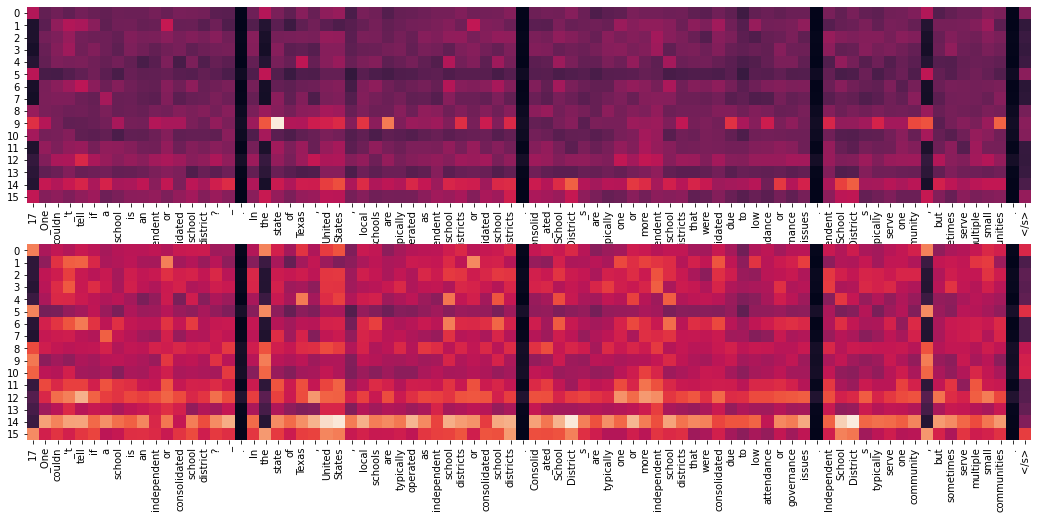

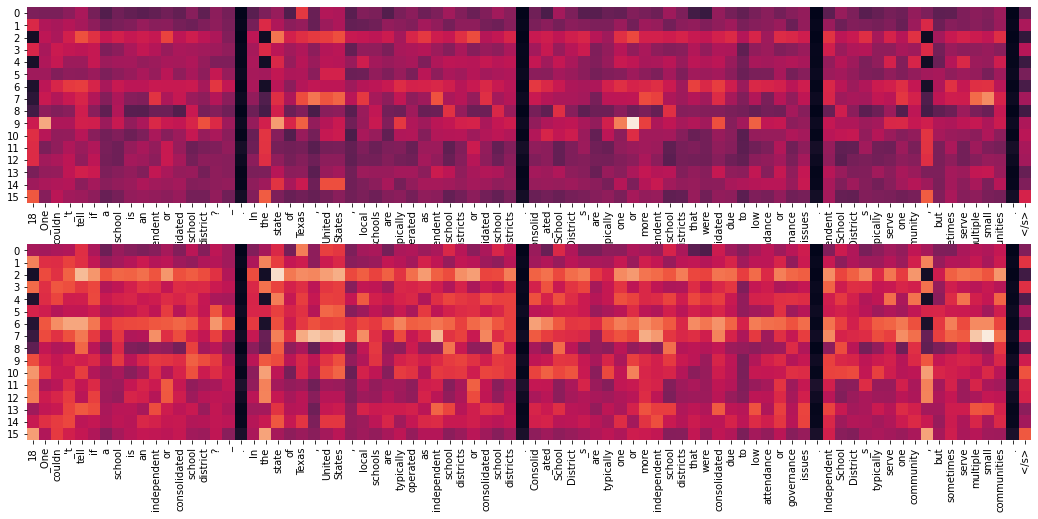

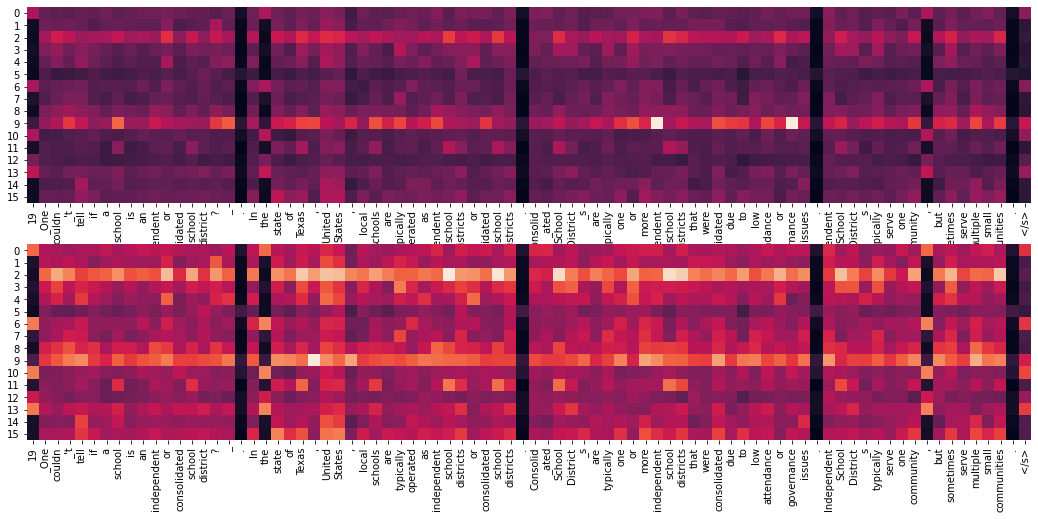

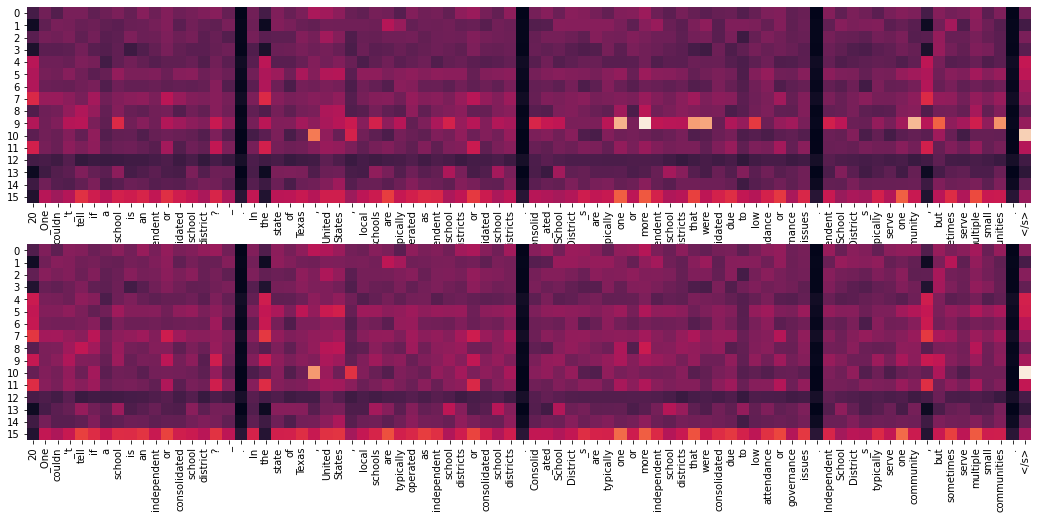

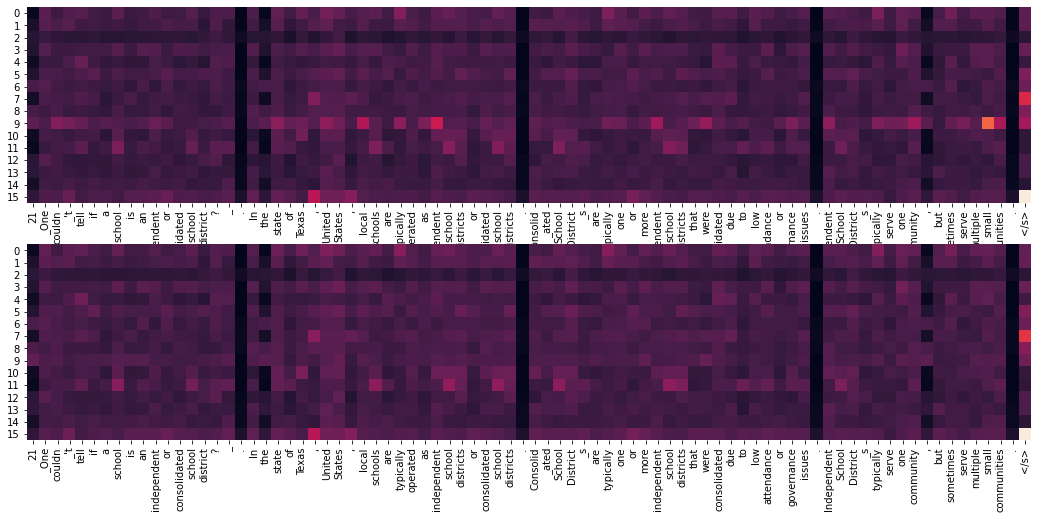

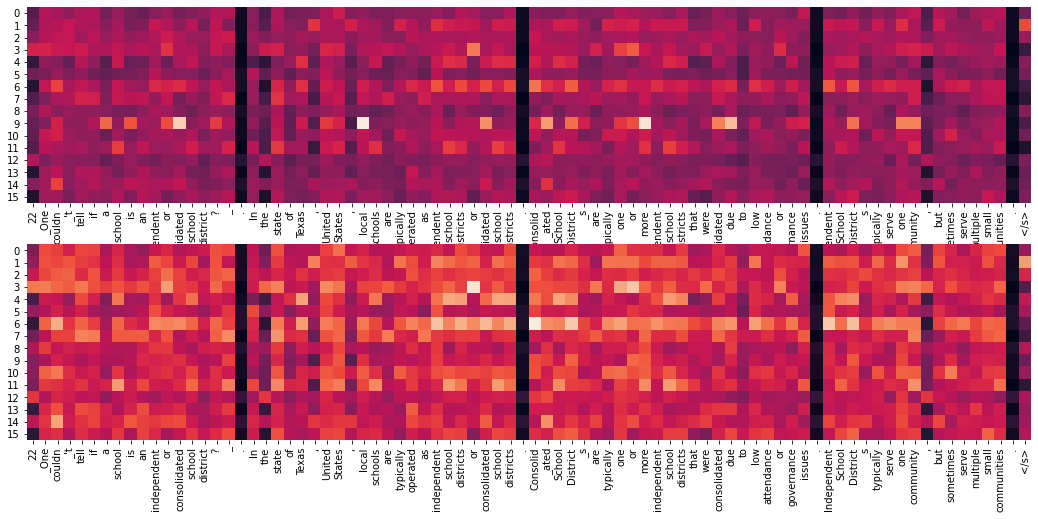

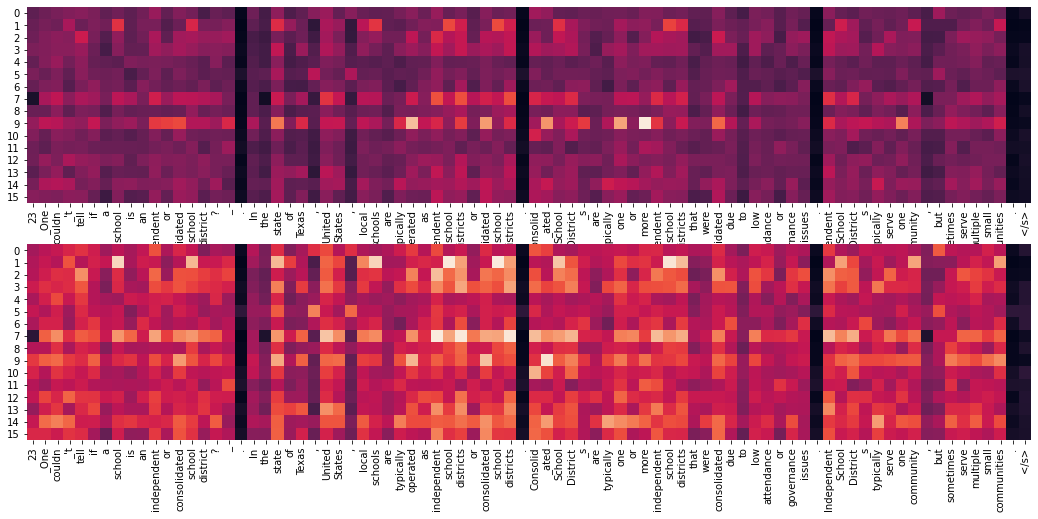

In [35]:
for i in range(L):
    v = model.roberta.encoder.layer[i].attention.self.value_layer  # (bsz, H, qlen, d_head)
    o = model.roberta.encoder.layer[i].attention.output.dense.weight.data  # (H, d_head, d_model)
    o = o.view(H, -1, model.config.hidden_size)
    # (bsz, H, qlen, d_head) * (H, d_head, d_model) = (bsz, H, qlen, d_model) -> (bsz, qlen, H, d_model) -> (bsz, qlen, H)
    norm0 = v.matmul(o).permute(0, 2, 1, 3).norm(dim=-1) #[0].t()
    norm1 = model.roberta.encoder.layer[i].attention.self.value_norm #[0].t()  # (bsz, qlen, H)

    # _ = plt.figure(figsize=(18,5))
    fig, axs = plt.subplots(2, 1, sharex=False, figsize=(18, 8))
    tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
    tokens[0] = str(i)
    for ax, norm in zip(axs, [norm0, norm1]):
        _ = sns.heatmap(norm[0].t().detach().cpu(), square=True, cbar=False, xticklabels=tokens, ax=ax)
        _ = plt.xticks(rotation=90)

/home/kf/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


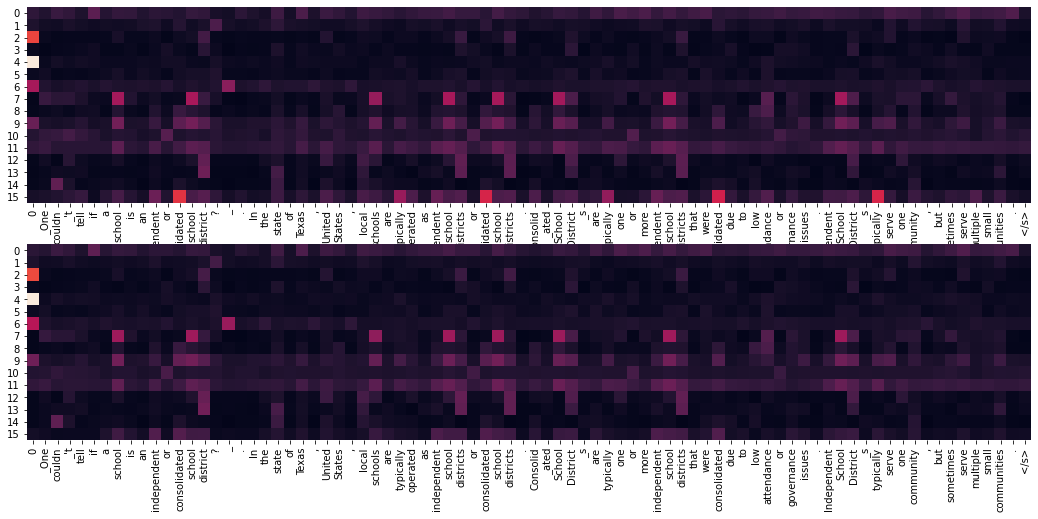

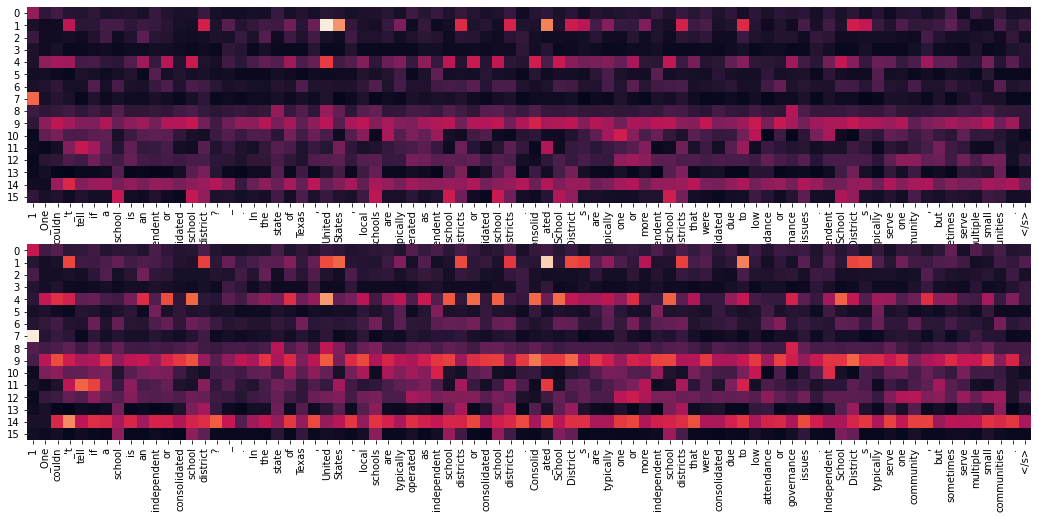

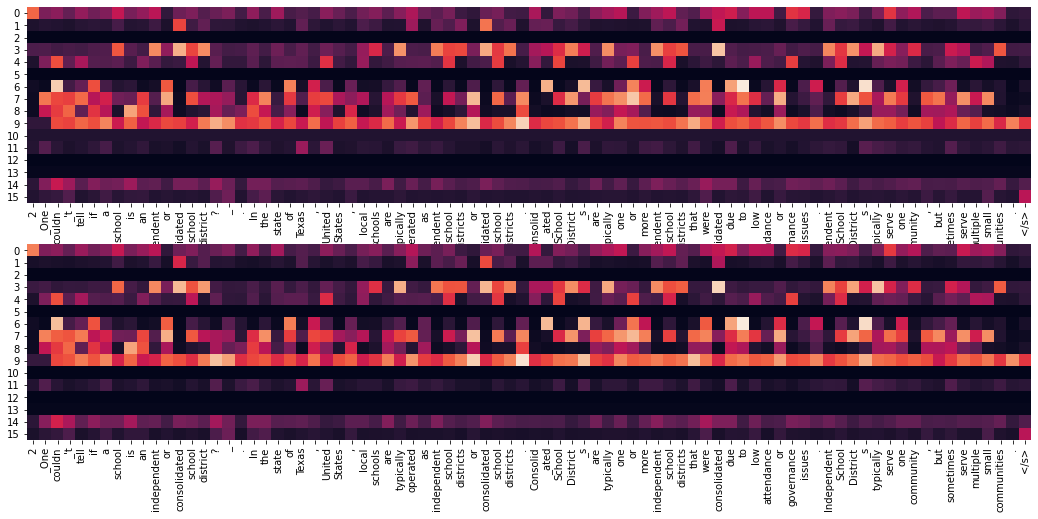

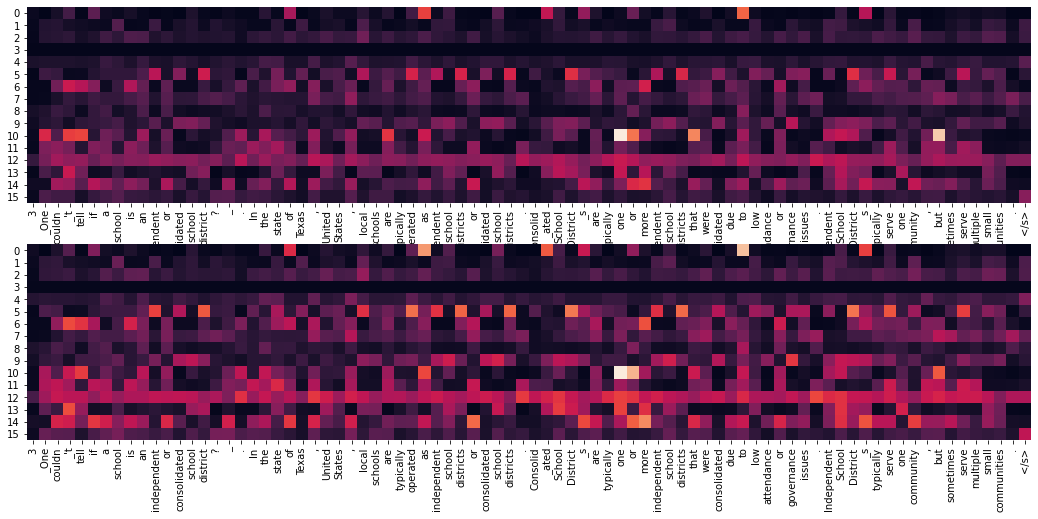

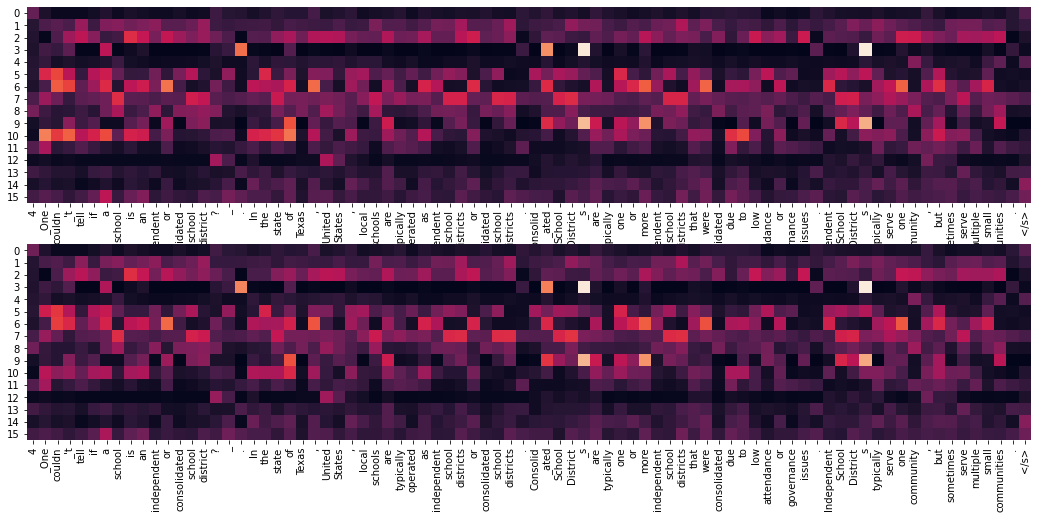

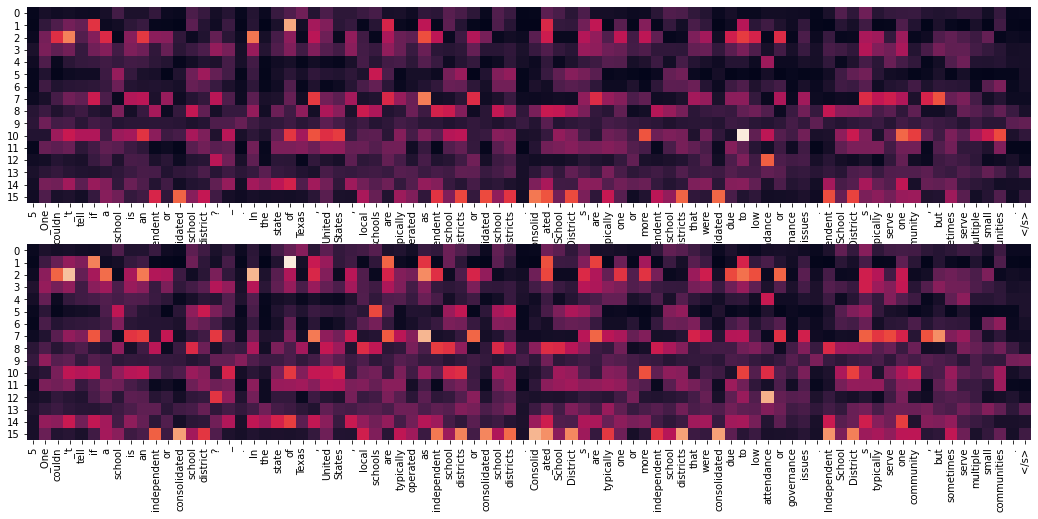

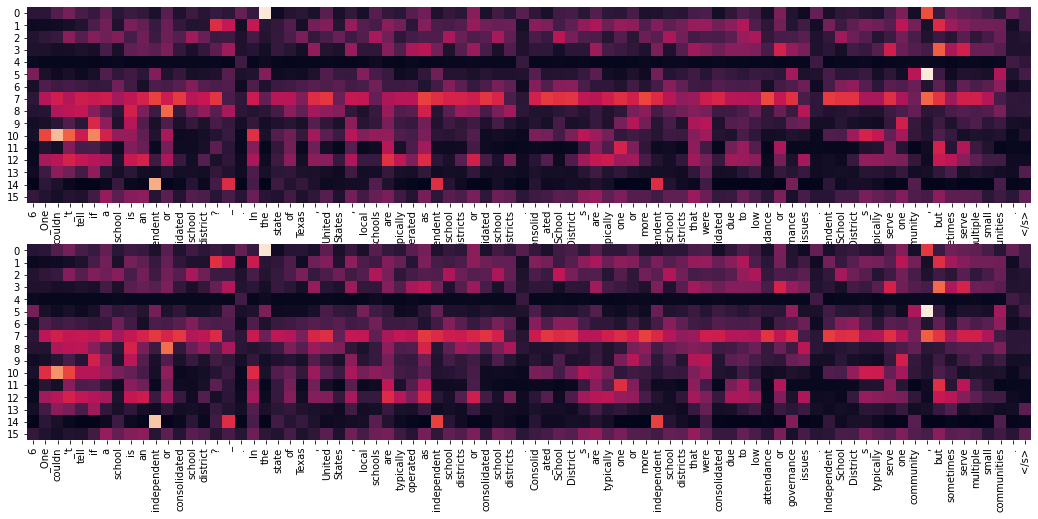

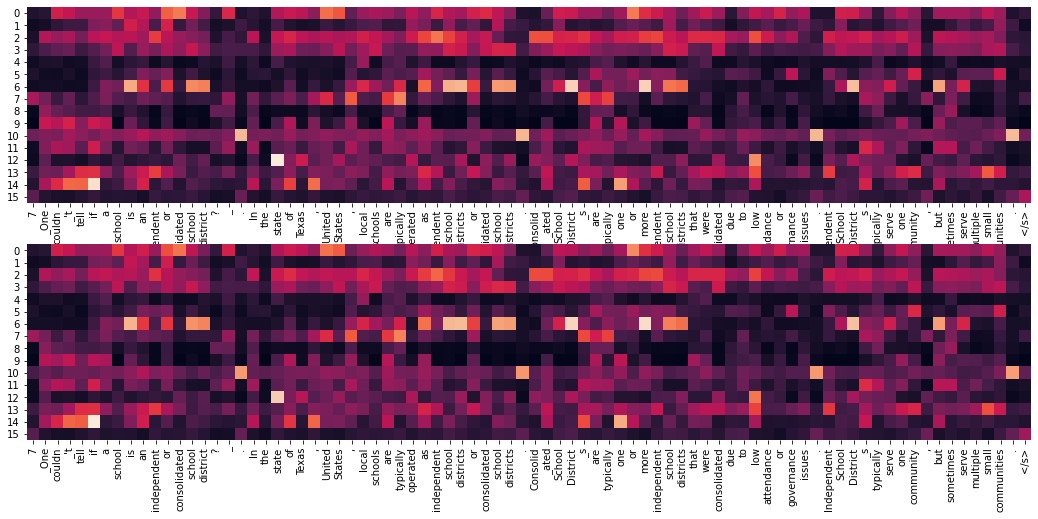

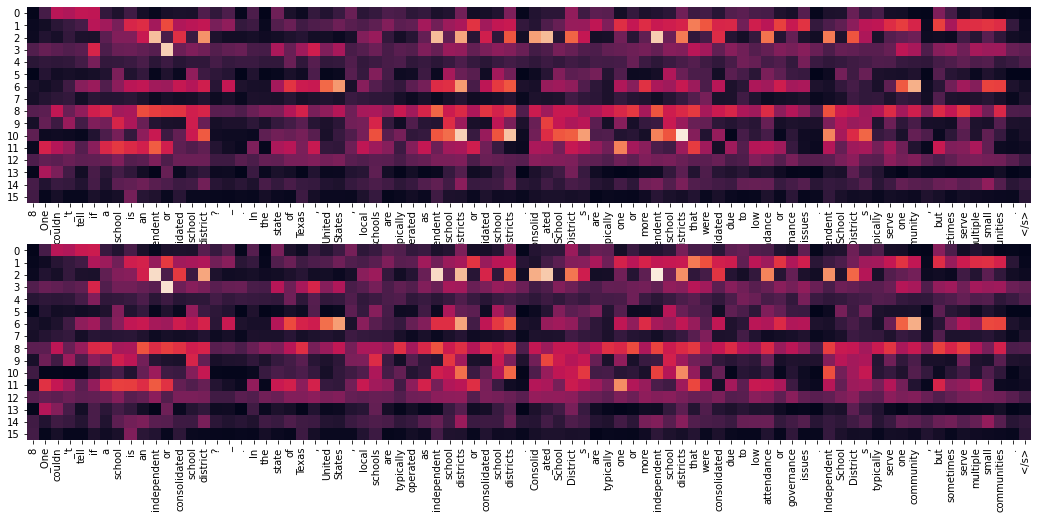

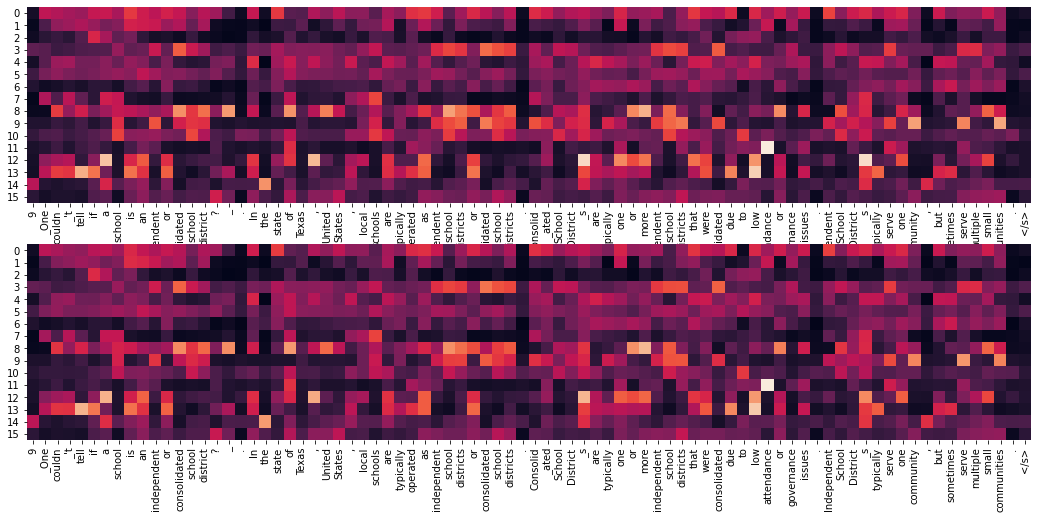

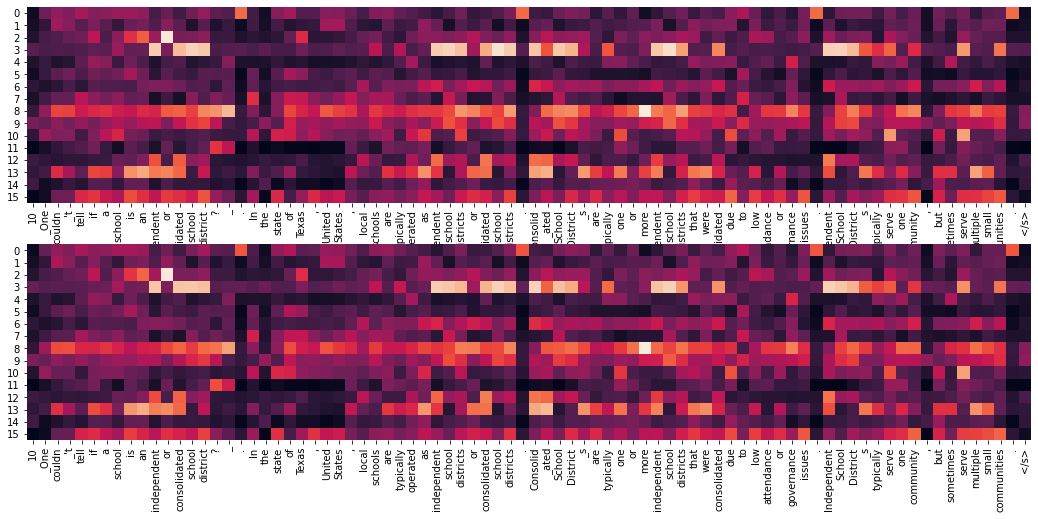

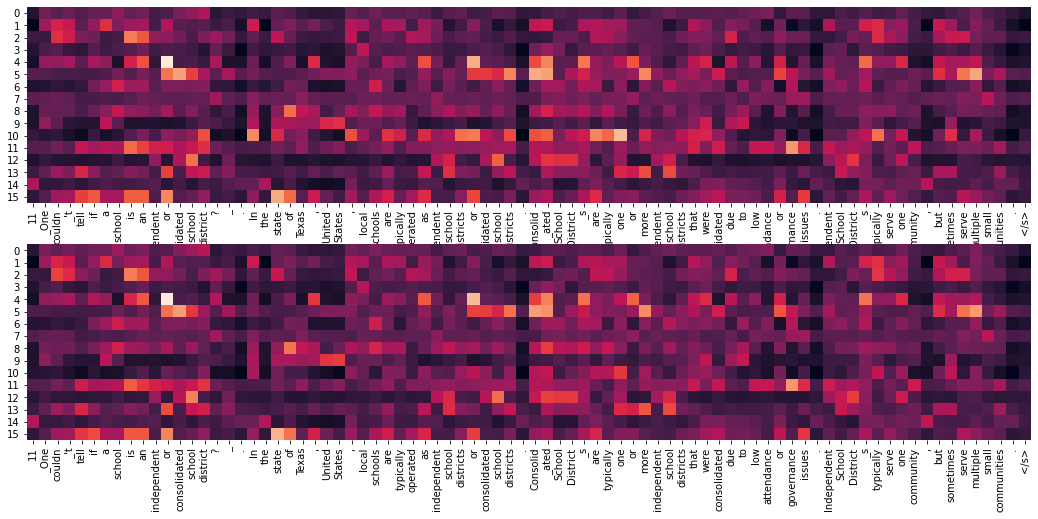

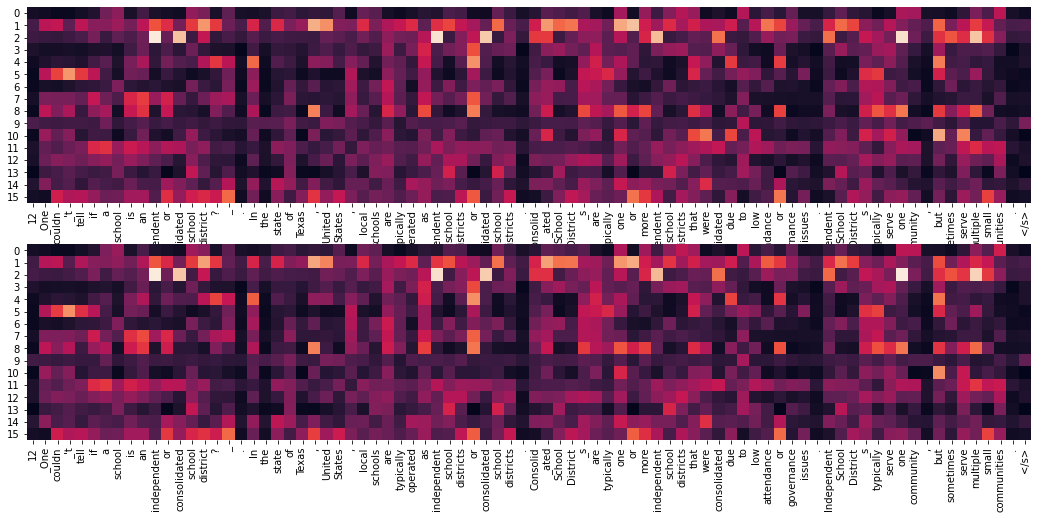

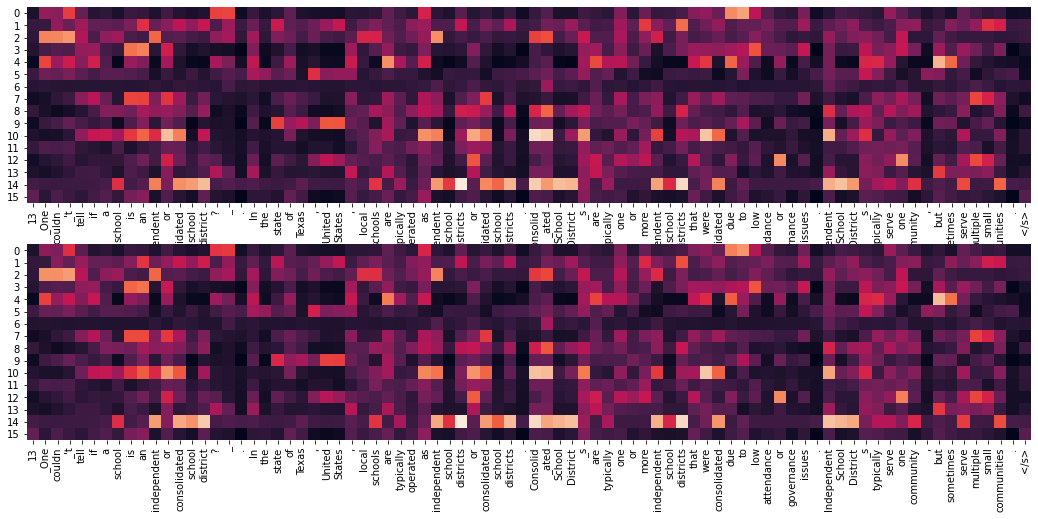

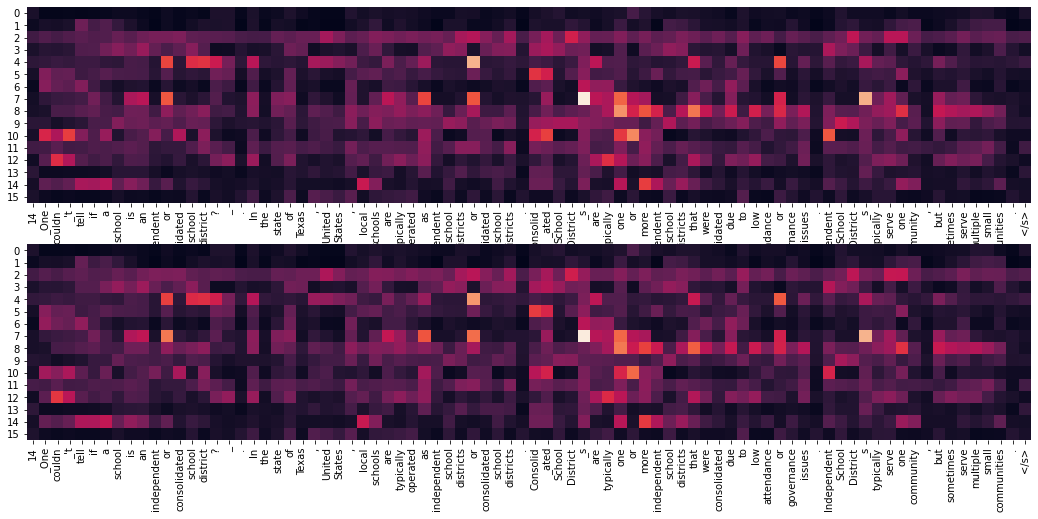

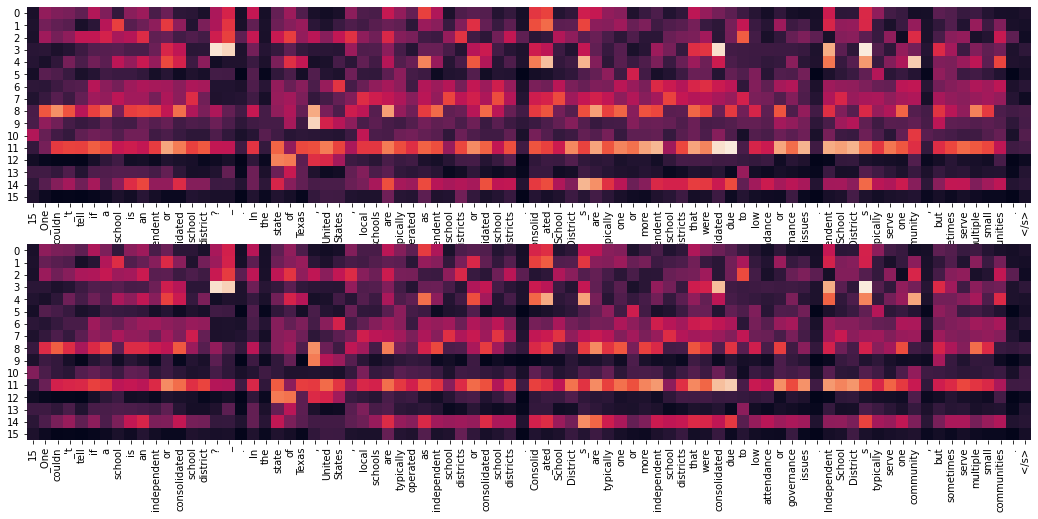

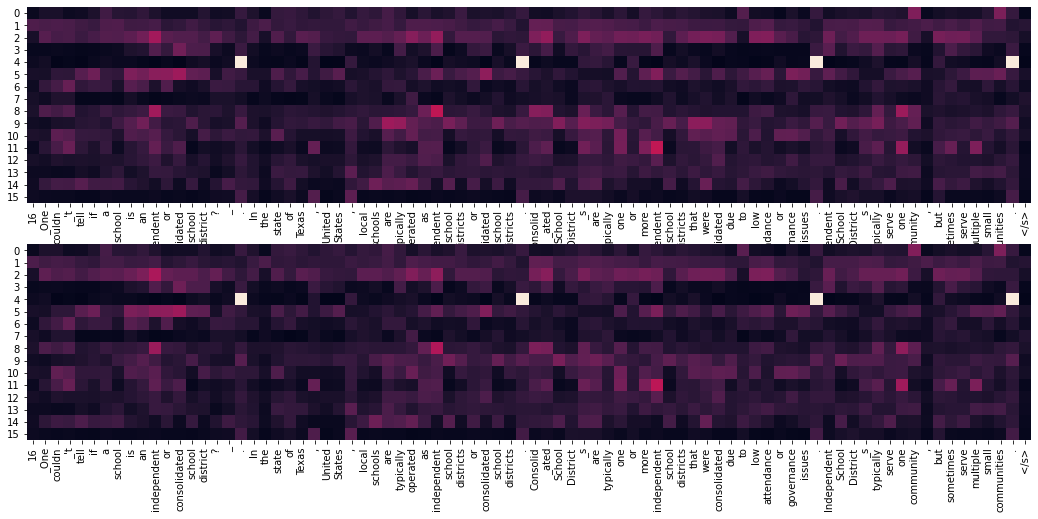

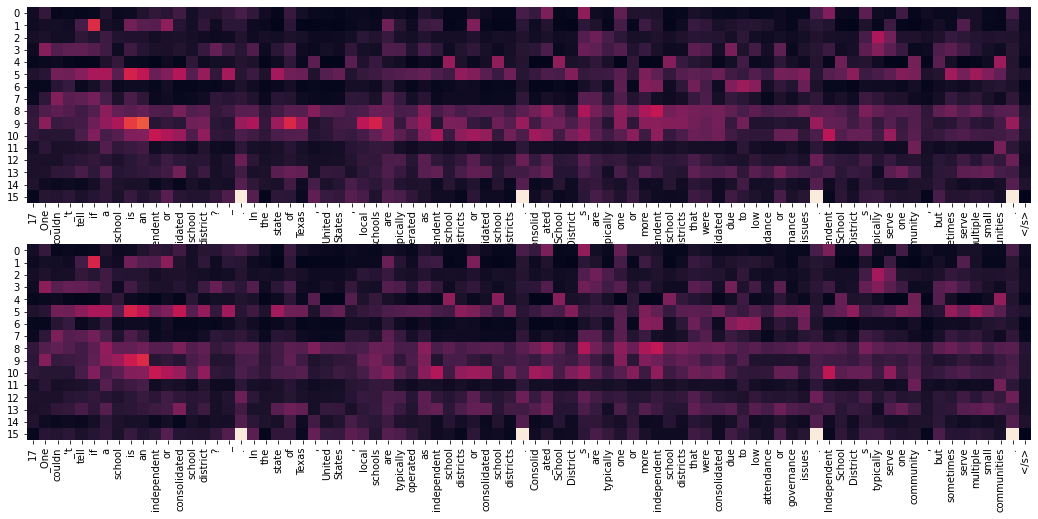

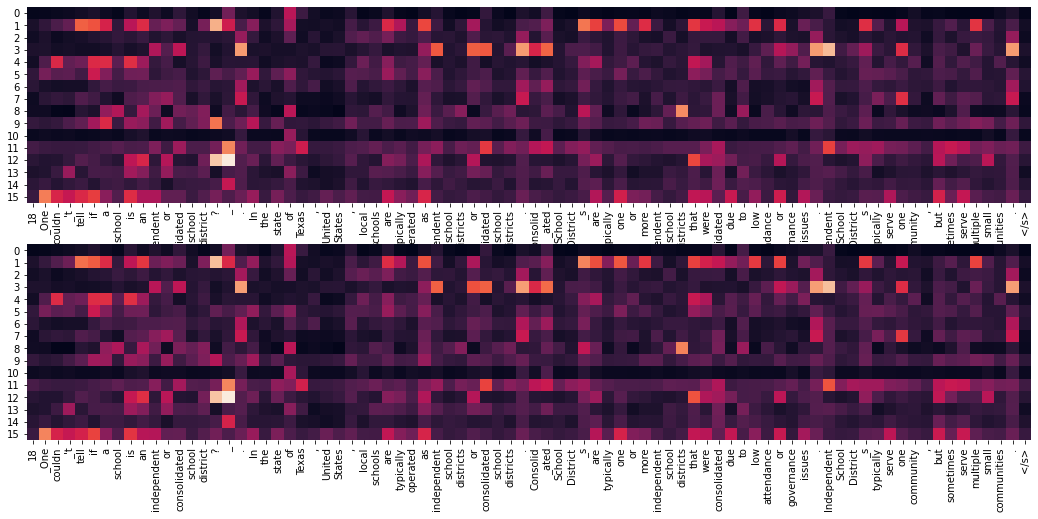

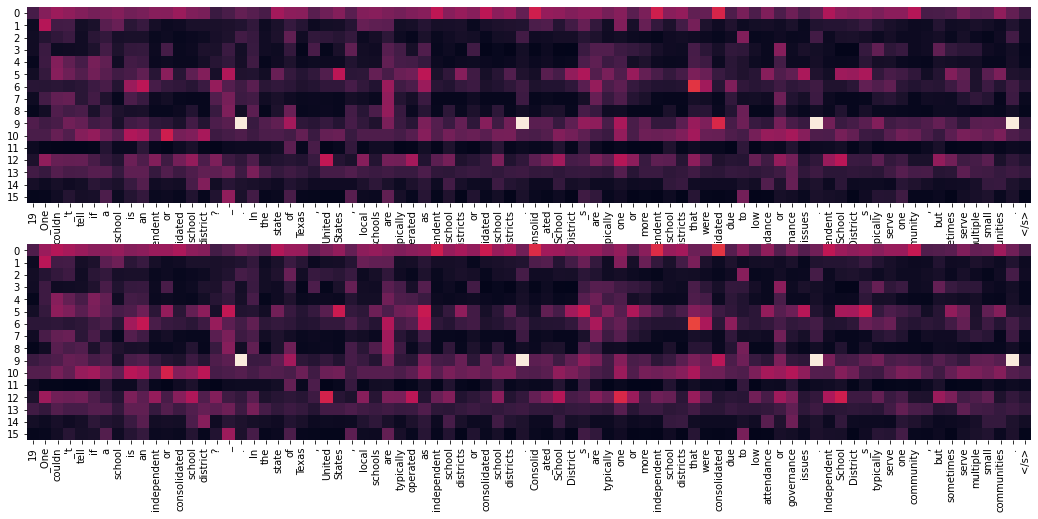

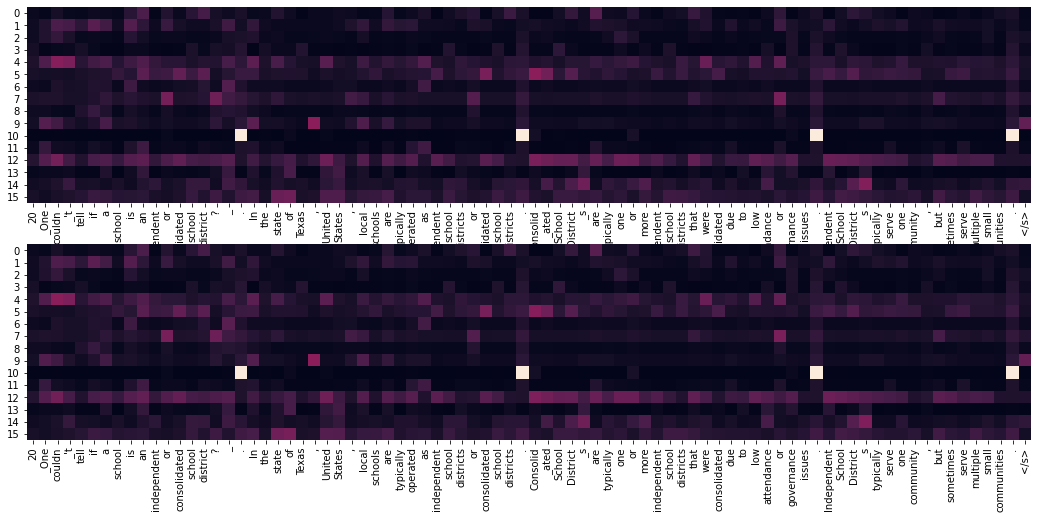

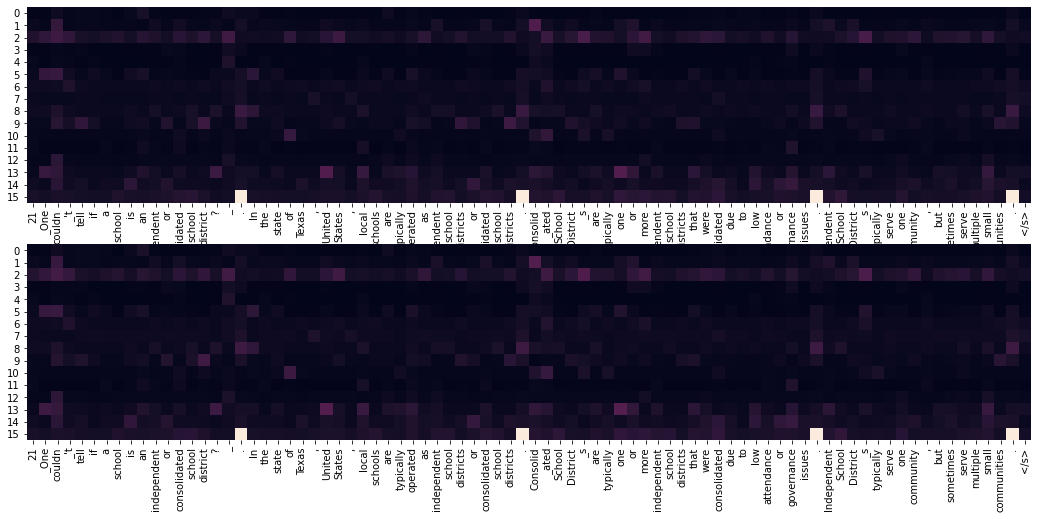

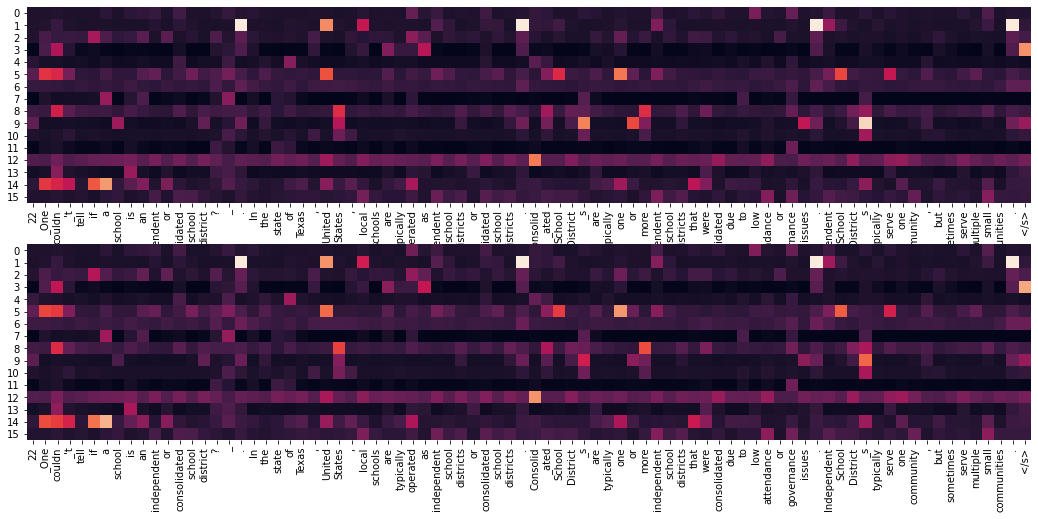

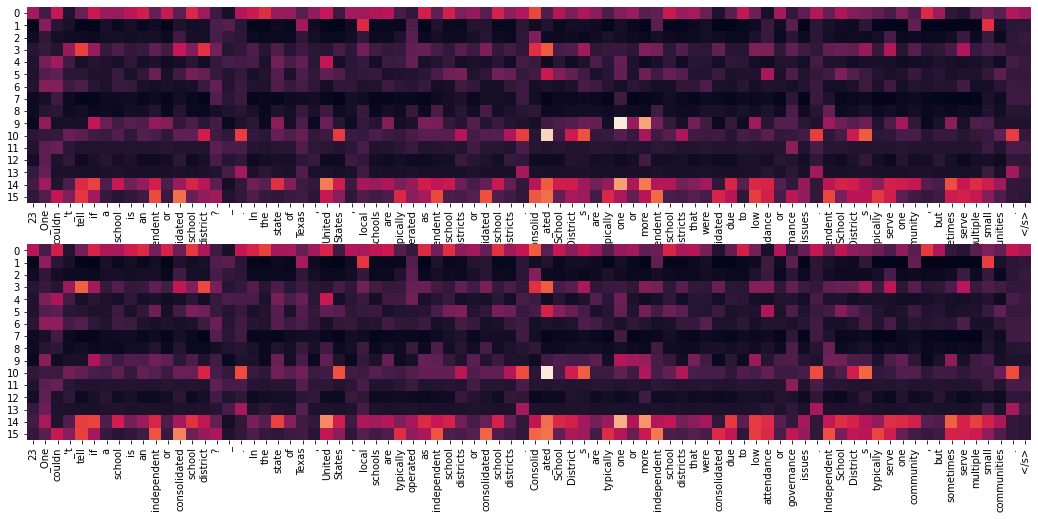

In [36]:
for i in range(L):
    v = model.roberta.encoder.layer[i].attention.self.context_layer  # (bsz, H, qlen, d_head)
    o = model.roberta.encoder.layer[i].attention.output.dense.weight.data  # (H, d_head, d_model)
    o = o.view(H, -1, model.config.hidden_size)
    # (bsz, H, qlen, d_head) * (H, d_head, d_model) = (bsz, H, qlen, d_model) -> (bsz, qlen, H, d_model) -> (bsz, qlen, H)
    norm0 = v.matmul(o).permute(0, 2, 1, 3).norm(dim=-1) #[0].t()
    norm1 = model.roberta.encoder.layer[i].attention.self.context_norm #[0].t()  # (bsz, qlen, H)

    # _ = plt.figure(figsize=(18,5))
    fig, axs = plt.subplots(2, 1, sharex=False, figsize=(18, 8))
    tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
    tokens[0] = str(i)
    for ax, norm in zip(axs, [norm0, norm1]):
        _ = sns.heatmap(norm[0].t().detach().cpu(), square=True, cbar=False, xticklabels=tokens, ax=ax)
        _ = plt.xticks(rotation=90)

In [61]:
import csv

with open('/nas/xd/data/nli/anli_annot_v0.2/ANLI_analysis_hard_dev.csv') as f:
    reader = csv.reader(f, delimiter=',')
    rows = [row for row in reader]

rows.insert(0, rows[0])

In [64]:
rows[22]

['Jamia Naeemia Lahore is an Islamic University in Lahore associated with the Sunni Barelvi movement. It was founded by Mufti Muhammad Husain Naeemi, father of Sarfraz Ahmed Naeemi. It serves as largest Sunni institution for the Barelvi movement in Pakistan.',
 'There are no smaller Sunni institutions for the Barelvi movement in Pakistan than Jamia Naeemia Lahore.',
 'It says that it is the largest institution, so there must be smaller ones.',
 'e',
 'c',
 'Tricky-Pragmatic, Basic-ComparativeSuperlative, Basic-Negation, Basic-Lexical-Similar',
 'biggest~smallest',
 '643a4d01-0fc0-46ff-b4b6-fff93f6dfd7d',
 '5414af53-e135-48db-b503-b0645bcb3dc8',
 'A1']

In [54]:
code = 'Reasoning-Facts'
[r[:7] for r in rows if code in r[5]]

[['Bucklow Rural District was, from 1894 to 1974, a local government district in the north of the administrative county of Cheshire, England. Following the Local Government Act 1972, this rural district was split between the new Greater Manchester boroughs of Trafford and Manchester, and Macclesfield, which was retained in Cheshire.',
  'Bucklow Rural District has a population.',
  'Bucklow Rural District must have a population if it is named location and not a historical site.',
  'n',
  'e',
  'Tricky-Pragmatic, Reasoning-Facts',
  ''],
 ['Tomato sauce (also known as Neapolitan sauce, and referred to in Italy as Salsa di pomodoro) refers to any of a very large number of sauces made primarily from tomatoes, usually to be served as part of a dish (rather than as a condiment). Tomato sauces are common for meat and vegetables, but they are perhaps best known as sauces for pasta dishes.',
  'Tomato sauce is only rarely used to top pasta.',
  'Salsa di pomodoro is made of peppers.',
  'e',

In [133]:
codes = defaultdict(int)
for r in rows[1:]:
    for code in r[5].split(', '):
        codes[code] += 1

sorted(codes.items(), key=lambda x: x[1], reverse=True)

[('Reasoning-Facts', 53),
 ('Basic-Negation', 39),
 ('Reference-Coreference', 38),
 ('Tricky-Pragmatic', 34),
 ('Basic-Lexical-Similar', 30),
 ('Tricky-Syntactic', 29),
 ('Tricky-Exhaustification', 21),
 ('Numerical-Cardinal', 21),
 ('Reasoning-Plausibility-Likely', 18),
 ('Reasoning-Plausibility-Unlikely', 16),
 ('Basic-Coordination', 15),
 ('Basic-ComparativeSuperlative', 15),
 ('Tricky-Wordplay', 14),
 ('Numerical-Ordinal', 13),
 ('Reference-Names', 13),
 ('Numerical-Cardinal-Dates', 10),
 ('Basic-CauseEffect', 8),
 ('Imperfection-Spelling', 8),
 ('Reasoning-Debatable', 7),
 ('Reasoning-Containment-Location', 7),
 ('Reasoning-Containment-Times', 7),
 ('Imperfection-Ambiguity', 6),
 ('Tricky-Translation', 6),
 ('Numerical-Cardinal-Nominal', 5),
 ('Numerical-Cardinal-Age', 5),
 ('Numerical-Cardinal-Counting', 4),
 ('Basic-Lexical-Dissimilar', 3),
 ('EventCoref', 3),
 ('Reference-Family', 3),
 ('Basic-Modus', 3),
 ('Numerical-Ordinal-Dates', 2),
 ('A1Code', 1),
 ('Basic-Idiom', 1),
 ('